<a href="https://colab.research.google.com/github/roydendsouza31/AI-Generated-Images-vs-Real-Images/blob/R1/CNN_Neyral_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AI Generated Images vs Real Images

In [3]:
from google.colab import drive
drive.mount('/content/drive')

!pip install kaggle

import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images

import zipfile

# Define the path to your zip file
file_path = '/content/cifake-real-and-ai-generated-synthetic-images.zip'  # Replace 'your_file.zip' with your file's name

!mkdir CIFAKE

# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/CIFAKE')  # Replace 'destination_folder' with your desired folder

Mounted at /content/drive
 99% 104M/105M [00:00<00:00, 174MB/s] 
100% 105M/105M [00:00<00:00, 171MB/s]


In [4]:
dataset_dir = "/content/CIFAKE" # For Kaggle notebooks. If you run locally, point this line to the CIFAKE directory
print("Loading dataset from: " + dataset_dir)

Loading dataset from: /content/CIFAKE


In [5]:
# Import all of the data using dataset from directory
# If there isn't enough RAM available, consider using Tensorflow Datasets

import tensorflow as tf

img_height = 32 # The dataset is all 32px but this is here just to make sure
img_width = 32
batch_size = 32

# Load the training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "/train",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Load the validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "/test",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=32)

# Quick sanity check to make sure it's all loaded properly
print("Training Classes:")
class_names = train_ds.class_names
print(class_names)

print("Testing Classes:")
class_names = train_ds.class_names
print(class_names)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Training Classes:
['FAKE', 'REAL']
Testing Classes:
['FAKE', 'REAL']


Displaying images from the training dataset:


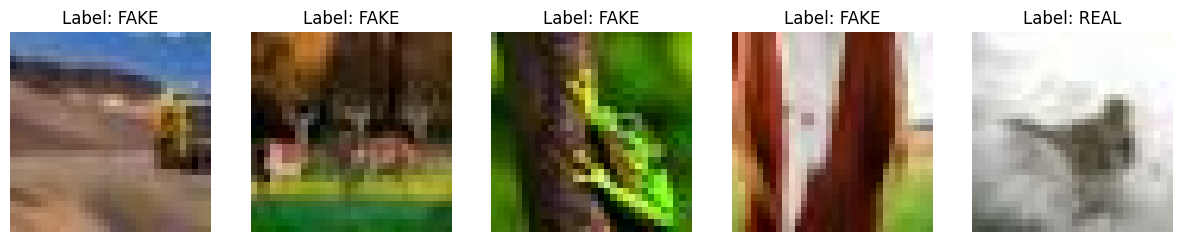

Displaying images from the validation dataset:


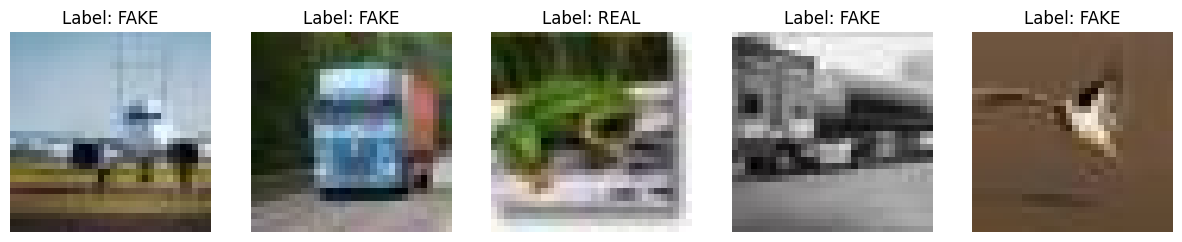

In [6]:
import matplotlib.pyplot as plt

# Function to display images from a TensorFlow dataset
def display_images(dataset, class_names, num_images=5):
    plt.figure(figsize=(15, 3))
    for images, labels in dataset.take(1):
        for i in range(min(num_images, len(images))):
            plt.subplot(1, num_images, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"Label: {class_names[labels[i]]}")
            plt.axis("off")
    plt.show()

# Displaying images from the training dataset
print("Displaying images from the training dataset:")
display_images(train_ds, class_names)

# Displaying images from the validation dataset
print("Displaying images from the validation dataset:")
display_images(val_ds, class_names)


In [7]:
# Building the CNN
layers = []
layers.append(tf.keras.layers.Rescaling(1./255)) # Normalise pixel values
layers.append(tf.keras.layers.Conv2D(32, 3, activation='relu'))
layers.append(tf.keras.layers.MaxPooling2D())
layers.append(tf.keras.layers.Flatten())

# Building the ANN
layers.append(tf.keras.layers.Dense(64, activation='relu'))
layers.append(tf.keras.layers.Dense(1, activation='sigmoid'))

# Create and compile the model from layers
model = tf.keras.Sequential(layers)
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Build the model so we can see a summary
model.build(input_shape=(None, 32, 32, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 7200)              0         
                                                                 
 dense (Dense)               (None, 64)                460864    
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

In [8]:
# Check if GPUs are available for training
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [9]:
# Finally, train the model

print("Starting training...")
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5,
  verbose=1
)

!mkdir TrainedModelSave
model.save("/content/TrainedModelSavenew") # Saving the model

print("Training finished.")

Starting training...
Epoch 1/5
3125/3125 [==============================] - 118s 37ms/step - loss: 0.3380 - accuracy: 0.8531 - precision: 0.8438 - recall: 0.8667 - val_loss: 0.2985 - val_accuracy: 0.8802 - val_precision: 0.9262 - val_recall: 0.8263
Epoch 2/5
3125/3125 [==============================] - 91s 29ms/step - loss: 0.2407 - accuracy: 0.9026 - precision: 0.8972 - recall: 0.9095 - val_loss: 0.2087 - val_accuracy: 0.9152 - val_precision: 0.9062 - val_recall: 0.9263
Epoch 3/5
3125/3125 [==============================] - 94s 30ms/step - loss: 0.2004 - accuracy: 0.9194 - precision: 0.9160 - recall: 0.9235 - val_loss: 0.2047 - val_accuracy: 0.9195 - val_precision: 0.9407 - val_recall: 0.8955
Epoch 4/5
3125/3125 [==============================] - 91s 29ms/step - loss: 0.1755 - accuracy: 0.9298 - precision: 0.9271 - recall: 0.9328 - val_loss: 0.1931 - val_accuracy: 0.9239 - val_precision: 0.9412 - val_recall: 0.9043
Epoch 5/5
3125/3125 [==============================] - 89s 28ms/step -

In [10]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model("/content/TrainedModelSavenew")

# Classify the test data
predictions = model.predict(val_ds)

import numpy as np

# Convert the predictions to class names
class_names = val_ds.class_names
predicted_classes = [class_names[int(np.round(prediction))] for prediction in predictions]

# Display the predictions
for image_batch, labels_batch in val_ds:
    for i in range(len(labels_batch)):
        print(f"Predicted class: {predicted_classes[i]}, True class: {class_names[int(labels_batch[i])]}")





625/625 [==============================] - 8s 12ms/step


<ipython-input-10-de153333c65e>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_classes = [class_names[int(np.round(prediction))] for prediction in predictions]


Streaming output truncated to the last 5000 lines.
Predicted class: FAKE, True class: FAKE
Predicted class: FAKE, True class: REAL
Predicted class: REAL, True class: FAKE
Predicted class: REAL, True class: FAKE
Predicted class: REAL, True class: FAKE
Predicted class: REAL, True class: FAKE
Predicted class: REAL, True class: FAKE
Predicted class: REAL, True class: FAKE
Predicted class: FAKE, True class: FAKE
Predicted class: REAL, True class: REAL
Predicted class: FAKE, True class: FAKE
Predicted class: FAKE, True class: REAL
Predicted class: REAL, True class: REAL
Predicted class: FAKE, True class: REAL
Predicted class: REAL, True class: FAKE
Predicted class: REAL, True class: FAKE
Predicted class: FAKE, True class: FAKE
Predicted class: FAKE, True class: FAKE
Predicted class: REAL, True class: REAL
Predicted class: FAKE, True class: REAL
Predicted class: FAKE, True class: FAKE
Predicted class: FAKE, True class: REAL
Predicted class: REAL, True class: REAL
Predicted class: FAKE, True c

625/625 [==============================] - 8s 12ms/step - loss: 0.1881 - accuracy: 0.9265 - precision: 0.9205 - recall: 0.9336
Test Loss: 0.18810994923114777, Test Accuracy: 0.9265000224113464, Test Precision: 0.9205284714698792, Test Recall: 0.9336000084877014
1/1 [==============================] - 0s 81ms/step


<ipython-input-11-9c54bdf16be9>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_classes = [class_names[int(np.round(prediction))] for prediction in predictions]


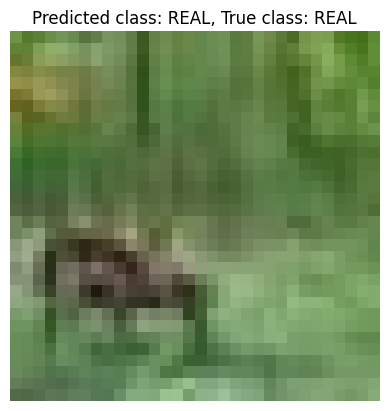

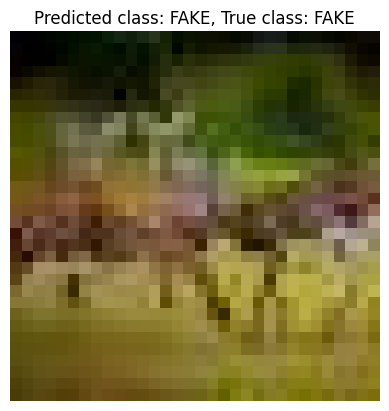

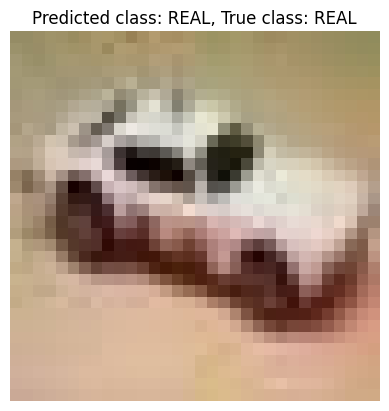

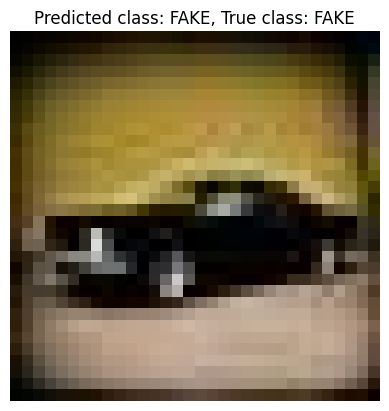

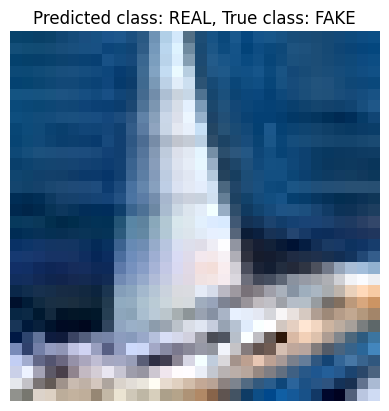

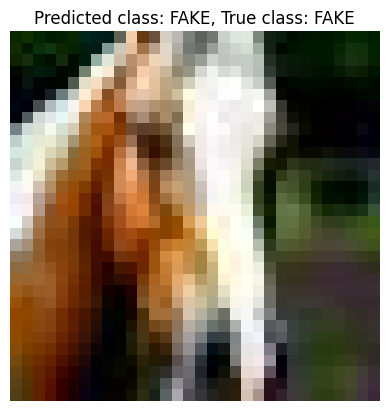

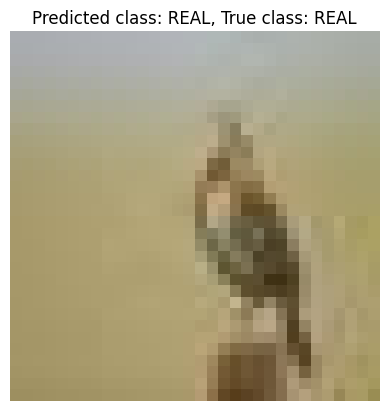

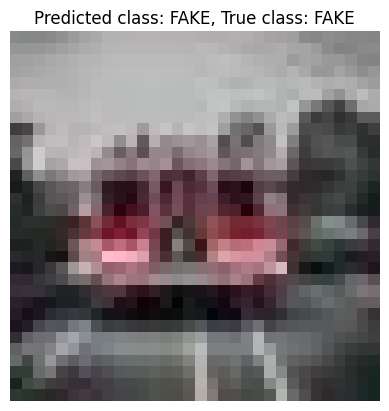

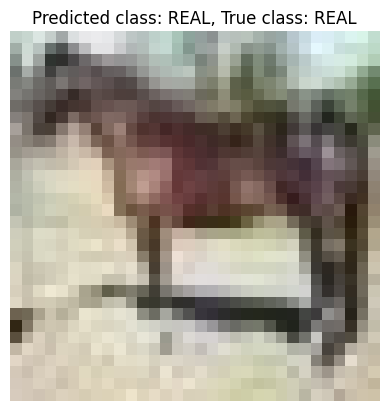

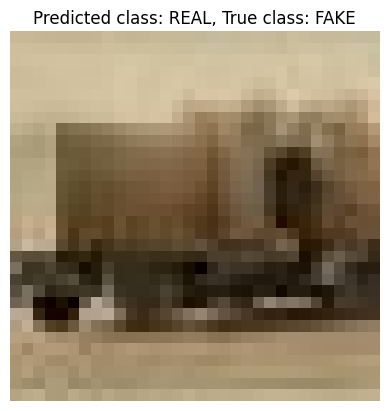

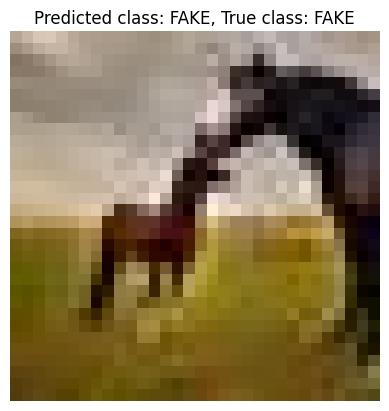

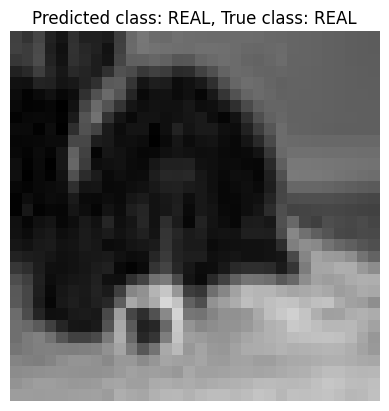

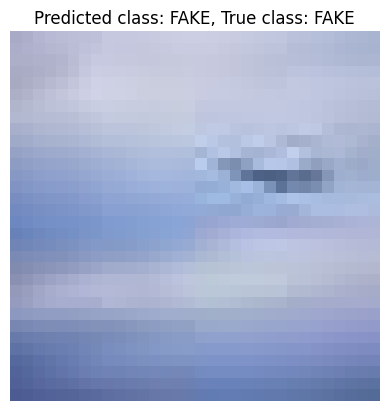

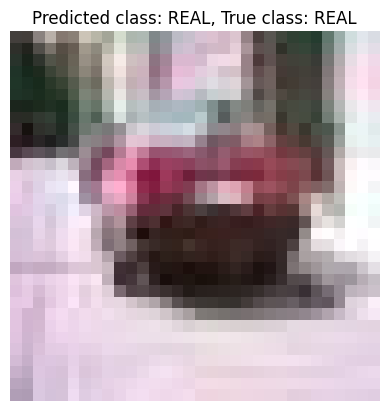

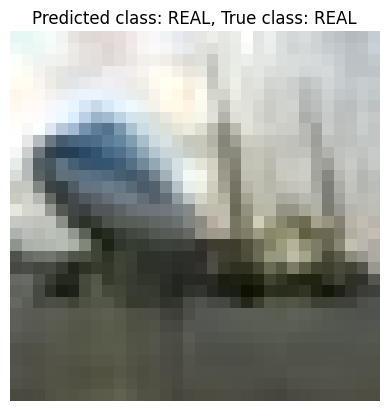

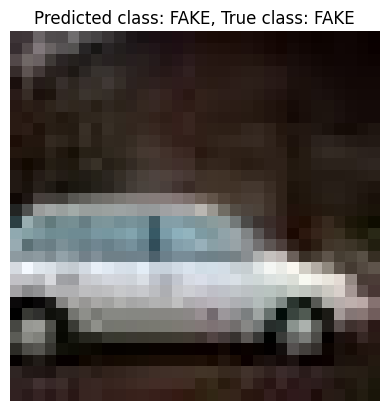

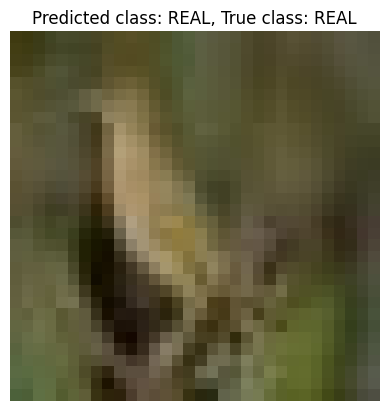

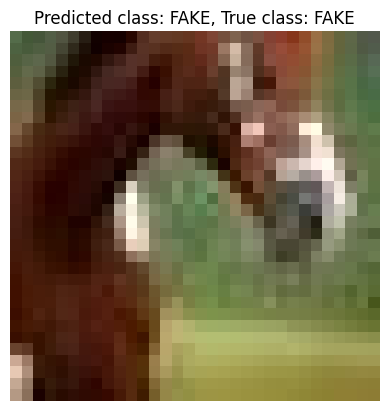

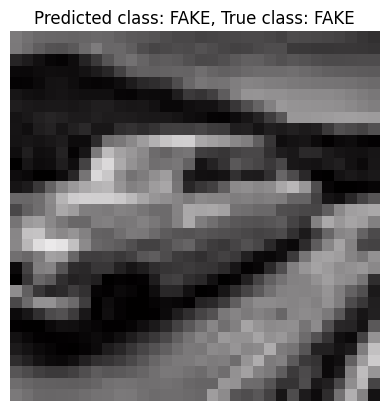

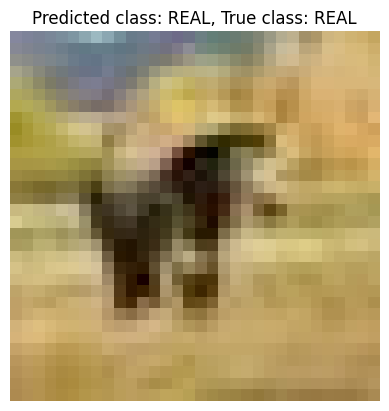

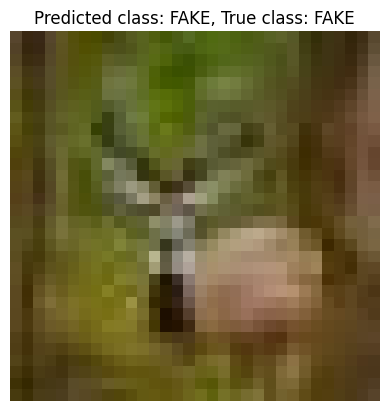

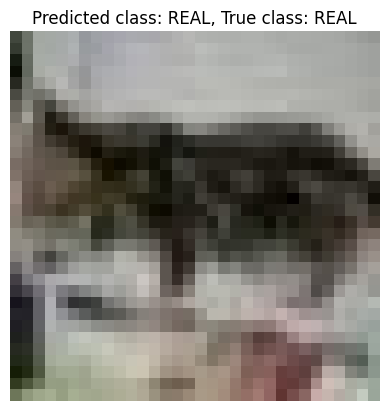

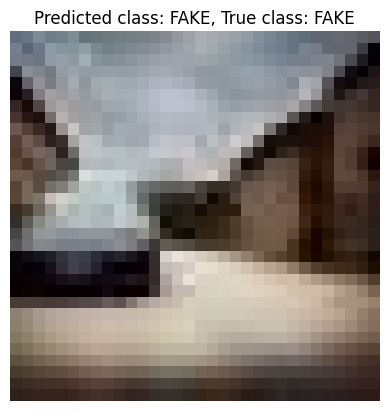

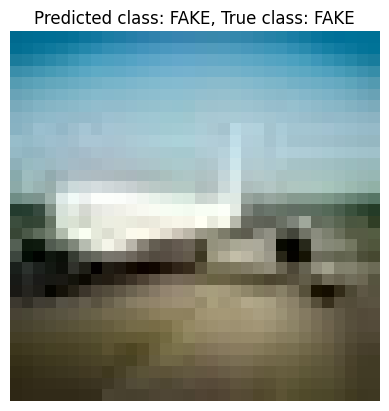

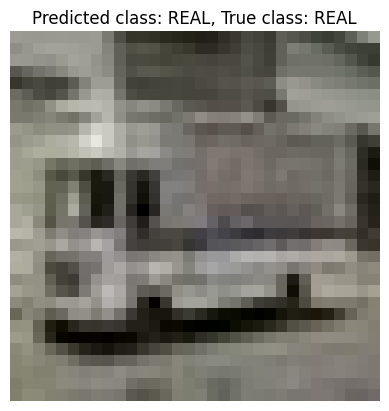

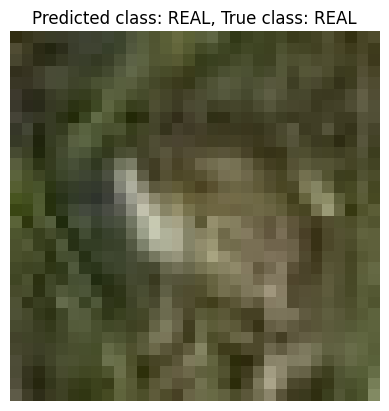

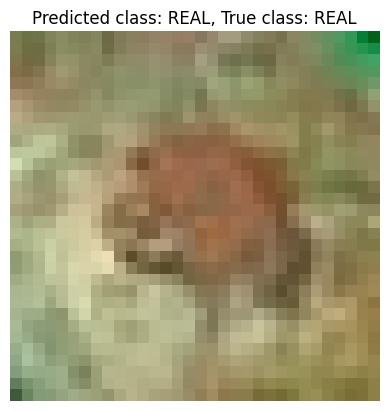

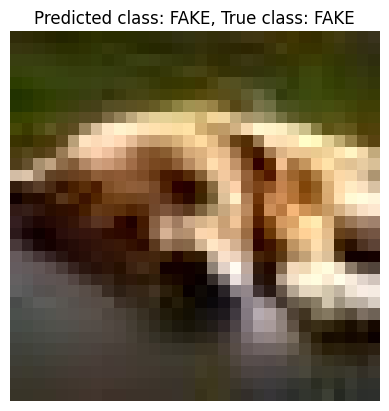

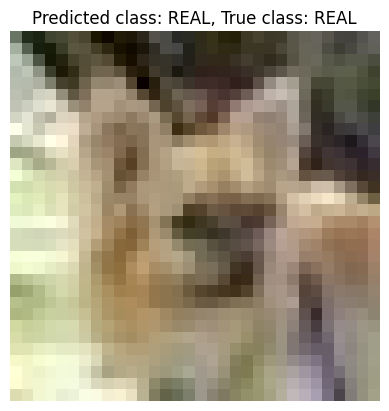

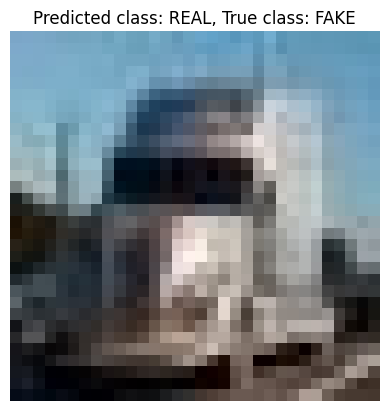

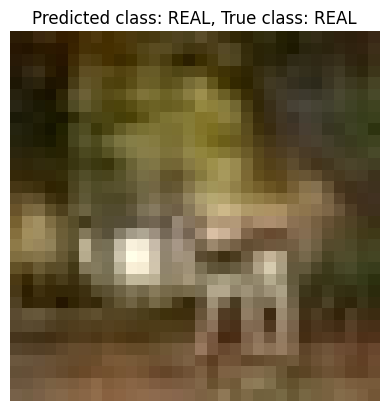

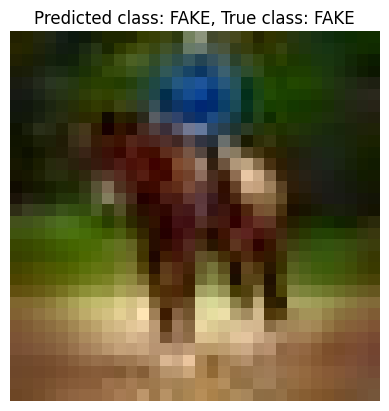

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model
model = tf.keras.models.load_model("/content/TrainedModelSavenew")

# Evaluate the model
test_loss, test_acc, test_precision, test_recall = model.evaluate(val_ds)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}, Test Precision: {test_precision}, Test Recall: {test_recall}")


# Get the class names from the test data
class_names = val_ds.class_names

# Get a batch of test images and their labels
for images, labels in val_ds.take(1):
    # Classify the images
    predictions = model.predict(images)
    predicted_classes = [class_names[int(np.round(prediction))] for prediction in predictions]

    # Display the images along with their predicted and true classes
    for i in range(len(images)):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Predicted class: {predicted_classes[i]}, True class: {class_names[int(labels[i])]}")
        plt.axis("off")
        plt.show()


In [12]:
!pip install gradio

In [15]:
import gradio as gr
import tensorflow as tf
import numpy as np

# Load the saved model
model = tf.keras.models.load_model("/content/TrainedModelSavenew")

# Function to preprocess the uploaded image and make predictions
def classify_image(image):
    # Preprocess the image
    image = tf.image.resize(image, (32, 32))  # Resize the image to match model input size
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    image = image / 255.0  # Normalize pixel values

    # Make prediction
    prediction = model.predict(image)

    # Convert prediction to class name
    class_names = ['Real', 'AI Generated']
    predicted_class = class_names[int(np.round(prediction))]

    return predicted_class

# Define the Gradio interface
interface = gr.Interface(fn=classify_image, inputs="image", outputs="label", title="AI Image Classifier", description="Upload an image to classify it as Real or AI Generated.")

# Launch the Gradio interface
interface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://9dd5429ccf1df86d63.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
